## Homework 04

SOLVED by ANGELA CARRARO

### Exercise 1

Let $\theta_1$ and $\theta_2$ be real valued parameters of the model

$$
y = \frac{\theta_1 x}{\theta_2 + x}.
$$

a. Choose two suitable prior distributions for $\theta_1$ and $\theta_2$  and use HMC algorithm to find their posterior distributions, conditioning on the observations

$$
x=(28,55,110,138,225,375)\\
y=(0.053,0.060,0.112,0.105,0.099,0.122).
$$

b. Discuss how different parameters for both priors and the HMC algorithm lead to different estimates. 

c. Plot the most reliable posterior distributions, according to convergence checks on the traces.

**Solution.**

a. Here we have a conditional distribution of $y$ given $x$, which we can express in this parametrized form:
$$p(y \mid x) = \frac{\theta_1 x}{\theta_2 + x}$$
where $\theta_1$ and $\theta_2$ are parameters that you consier as two random variables, and we are trying to compute a posterior ditribution over them given that we observed $x$ and $y$.

Or alternatively we can think that we have a set of observations of $x$ and $y$ and our goal is to identify the proper model that generates these observations. So we are talking about a conditional kind of problem.

To choose the prior distributions for $\theta_1$ and $\theta_2$ we first observe that all the number are positive.
Suitable here doen't refer to the numbers but just to the dimension of tensors you want to get as an output.
Think about that $\theta_i$ are real numbers. The simple distribution on real numbers that is tipically used as a prior is the normal distibution. Or also an exponential or lognormal or an Inverse Gamma or an Half Cauchy distribution, everything that is consistent is fine. NO a categorical distribution over $\{0, 1\}$ or a Bernoulli distribution.

In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
pyro.set_rng_seed(0)

In [104]:
def model(x):
    with pyro.plate('theta'):
        theta1 = pyro.sample("theta1", dist.Exponential(5.))
        theta2 = pyro.sample("theta2", dist.Normal(5., 7.))
    y = pyro.param("y", (theta1 * x)/(theta2 + x))
    return y

In [105]:
# measurement observations
xobs = torch.tensor([28, 55, 110, 138, 225, 375])
yobs = torch.tensor([0.053, 0.060, 0.112, 0.105, 0.099, 0.122])

conditioned_model = pyro.condition(model, data={"y": yobs})
conditioned_model(xobs)

hmc_kernel = HMC(model=conditioned_model) # transition kernel
mcmc = MCMC(hmc_kernel, num_samples=500, warmup_steps=1000, num_chains=3)

# posteriors 
posterior = mcmc.run(xobs)

# dictionary of sampled values
print(mcmc.get_samples().keys())
mcmc.summary()




dict_keys(['theta1', 'theta2'])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      0.24      0.23      0.15      0.01      0.57    114.88      1.03
    theta2      6.01      8.05      5.37     -6.11     18.75     19.84      1.13

Number of divergences: 0


b. Different parameters for both priors and the HMC algorithm lead to different estimates, in fact if we change the parameters in the priors distribution we will get different values for $\theta_1$ and $\theta_2$. This is because the posterior probability is an update of our prior information contained in the prior probability, it is build over the prior, so if we change the latter also the former will change, and so will change the estimates of the parameters. $\color{red}{!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!}$

c. The plot of the most reliable posterior distributions, according to convergence checks on the traces, is:

torch.Size([3, 500])


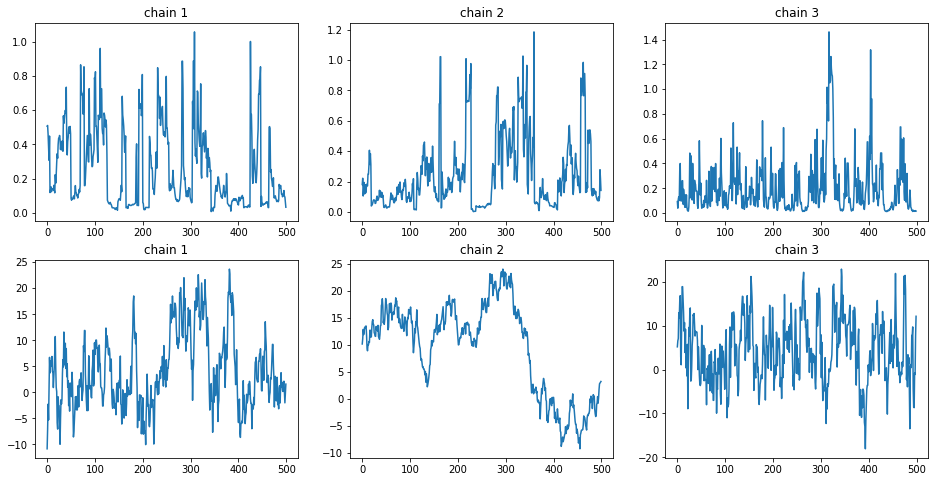

In [115]:
# extracting weight samples and grouping them by chains
mcmc_samples = mcmc.get_samples(group_by_chain=True)
chains1 = mcmc_samples["theta1"]
chains2 = mcmc_samples["theta2"]

n_chains, n_samples = chains1.shape
print(chains.shape)

fig, ax = plt.subplots(2, n_chains, figsize=(16,8))
for i, chain in enumerate(chains1):
    sns.lineplot(x=range(n_samples), y=chain, ax=ax[0, i])
    ax[0, i].set_title("chain "+str(i+1))
for i, chain in enumerate(chains2):
    sns.lineplot(x=range(n_samples), y=chain, ax=ax[1, i])
    ax[1, i].set_title("chain "+str(i+1))

expected theta1 = 0.23622889816761017
expected theta2 = 6.012410640716553


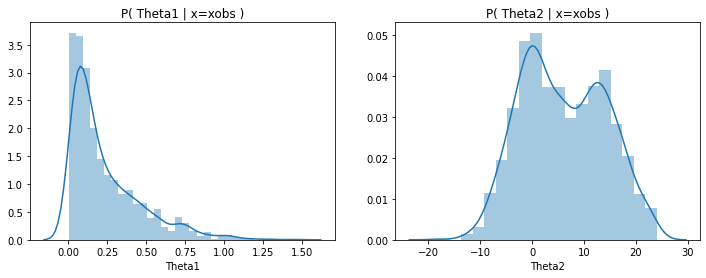

In [107]:
print("expected theta1 =", mcmc_samples['theta1'].mean().item())
print("expected theta2 =", mcmc_samples['theta2'].mean().item())

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.distplot(mcmc_samples['theta1'], ax=axes[0])
sns.distplot(mcmc_samples['theta2'], ax=axes[1])
axes[0].set_title("P( Theta1 | x=xobs )")
axes[0].set_xlabel("Theta1")
axes[1].set_title("P( Theta2 | x=xobs )")
axes[1].set_xlabel("Theta2")
plt.show()

### Exercise 2

A bivariate Gibbs sampler for a vector $x=(x_1,x_2)$ draws iteratively from the posterior conditional distributions in the following way:
- choose a starting value $p(x_1|x_2^{(0)})$
- for each iteration $i$:
    - draw $x_2(i)$ from $p(x_2|x_1^{(i-1)})$
    - draw $x_1(i)$ from $p(x_1|x_2^{(i)})$

a. Supposing that samples are drawn from a bivariate normal distribution

$$
{x_1 \choose x_2} \sim \mathcal{N} \Bigg[ {0 \choose 0} , \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \Bigg],
$$
    implement a Gibbs sampler for $x$ which takes as inputs the number of iterations `iters` and the number of warmup draws `warmup`.

b. Use your implementation of Gibbs sampler to infer the parameters $\theta=(\theta_1,\theta_2)$ from **Exercise 1**.

**Solution.**



a. The Gibbs sampler is:

In [116]:
def GibbsSampler(iters, warmup):
    rho = 0.3
    mu = torch.zeros(2);
    sigma = torch.ones(2,2)
    sigma[0,1] = sigma[1,0] = rho
    
    x = []
    xx = torch.zeros(2);
    xx[0] = pyro.sample("x01", dist.Normal(0, rho))
    
    for i in range(warmup + iters):
        xx[1] = pyro.sample("x2", dist.Normal(rho * xx[0], 1. - rho**2))
        if(i > warmup):
            x.append(copy.deepcopy(xx))
        xx[0] = pyro.sample("x1", dist.Normal(rho * xx[1], 1. - rho**2))

    return x

In [78]:
GibbsSampler(500, 100)

[tensor([ 0.6269, -0.1248]),
 tensor([ 0.2409, -0.4595]),
 tensor([0.0284, 0.4491]),
 tensor([-0.8065, -0.8880]),
 tensor([ 0.9075, -0.7351]),
 tensor([-1.1046, -0.8091]),
 tensor([-0.6791,  0.1183]),
 tensor([ 0.2314, -1.2318]),
 tensor([-0.2873,  0.6260]),
 tensor([0.5077, 0.0961]),
 tensor([-1.4701, -2.2393]),
 tensor([-0.1886, -1.3091]),
 tensor([-0.9556, -0.7068]),
 tensor([-0.0065, -0.1517]),
 tensor([ 0.3170, -0.1627]),
 tensor([-0.9886,  0.2836]),
 tensor([-0.3945, -0.2922]),
 tensor([0.5988, 0.4713]),
 tensor([1.1780, 0.5234]),
 tensor([0.8780, 1.0610]),
 tensor([ 0.6957, -0.1778]),
 tensor([-0.4655, -0.7452]),
 tensor([-0.2297, -0.9050]),
 tensor([-1.5996, -0.5546]),
 tensor([-1.0514, -0.5697]),
 tensor([ 0.5532, -0.0459]),
 tensor([1.3685, 0.3381]),
 tensor([-0.0798,  0.7202]),
 tensor([ 0.8034, -0.2642]),
 tensor([0.2362, 0.3796]),
 tensor([ 0.3789, -0.0377]),
 tensor([ 1.7571, -0.3011]),
 tensor([ 0.1861, -0.3133]),
 tensor([-0.8244, -0.8975]),
 tensor([-1.5436,  0.5536]),

b. We infer the parameters $\theta = (\theta_1, \theta_2)$ from **Exercise 1**:

In [45]:
def GibbsSampler(iters, warmup):

    xx[0] = 5
    
    for i in range(warmup + iters):
        xx[1] = pyro.sample("theta1", dist.Exponential(5.))
        if(i > warmup):
            x.append(copy.deepcopy(xx))
        xx[0] = pyro.sample("theta2", dist.Normal(5., 7.))

    return x